In [90]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt 
from matplotlib import style
%matplotlib inline
import mpld3

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

import datetime as dt
import calendar

import seaborn as sns

In [28]:
original_data = pd.read_csv('Philly_python_data.csv')
original_data.head()

,record number,datetime,season,holiday,weather,temp,humidity,windspeed,casual,registered,all_users
0,1,1/14/12 6:00,1,0,1,-2.0,50,0.0,0,5,5
1,2,7/24/11 4:00,3,0,1,30.0,66,7.0,1,5,6
2,3,10/9/11 7:00,4,0,1,13.0,86,0.0,18,26,44
3,4,12/12/12 21:00,4,0,2,6.0,52,17.0,16,186,202
4,5,6/22/11 13:00,3,0,2,32.0,56,17.0,33,112,145


In [29]:
data = original_data.copy()
count_nan = data.isnull().sum()
print(count_nan)

record number    0
datetime         0
season           0
holiday          0
weather          0
temp             0
humidity         0
windspeed        0
casual           0
registered       0
all_users        0
dtype: int64


## Clearly errors in temp data

Text(0, 0.5, 'Temp(C)')

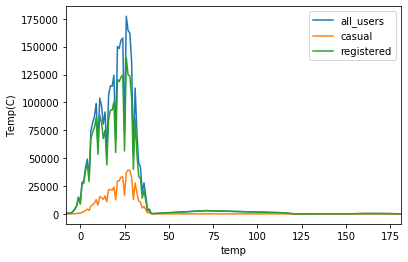

In [30]:
temp_pivot = data.pivot_table(index='temp', values=['all_users', 'casual', 'registered'], aggfunc='sum')
temp_pivot.plot()
plt.ylabel('Temp(C)')

## Removing outliers

In [31]:
std = data['temp'].std()
mean = data['temp'].mean()

In [32]:
len(data)

17513

In [33]:
data_copy = data.copy()
std = data['temp'].std()
mean = data['temp'].mean()
count = 0
for i in range(len(data)):
    if data_copy['temp'][i] > (mean + 4*std):
        data_copy.drop(i, inplace=True)
        count += 1
len(data_copy)

17459

Text(0.5, 1.0, 'Rentals are higher in higher temperatures')

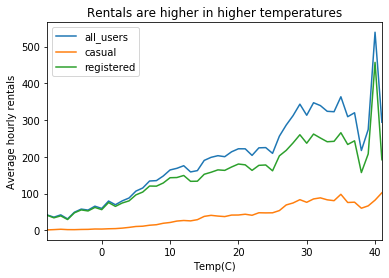

In [34]:
data_copy.reset_index(drop=True, inplace=True)
data = data_copy
temp_pivot = data.pivot_table(index='temp', values=['all_users', 'casual', 'registered'])
temp_pivot.plot()
plt.xlabel('Temp(C)')
plt.ylabel('Average hourly rentals')
plt.title('Rentals are higher in higher temperatures')

### Encoding categorical variables

In [35]:
data['season'].replace(to_replace={1:'winter', 2:'spring', 3:'summer', 4:'fall'}, inplace=True)
season = data['season']
season_encoded = pd.get_dummies(season)
season_encoded.head()

,fall,spring,summer,winter
0,0,0,0,1
1,0,0,1,0
2,1,0,0,0
3,1,0,0,0
4,0,0,1,0


In [36]:
#creating dummy variables for weather
data['weather'].replace(to_replace={1:'clear', 2:'mist', 3:'precipitation'}, inplace=True)
weather = data['weather']
weather_encoded = pd.get_dummies(weather)
weather_encoded.head()

,clear,mist,precipitation
0,1,0,0
1,1,0,0
2,1,0,0
3,0,1,0
4,0,1,0


In [37]:
joined = season_encoded.join(weather_encoded)
processed_data = data.join(joined)
processed_data.head()

,record number,datetime,season,holiday,weather,temp,humidity,windspeed,casual,registered,all_users,fall,spring,summer,winter,clear,mist,precipitation
0,1,1/14/12 6:00,winter,0,clear,-2.0,50,0.0,0,5,5,0,0,0,1,1,0,0
1,2,7/24/11 4:00,summer,0,clear,30.0,66,7.0,1,5,6,0,0,1,0,1,0,0
2,3,10/9/11 7:00,fall,0,clear,13.0,86,0.0,18,26,44,1,0,0,0,1,0,0
3,4,12/12/12 21:00,fall,0,mist,6.0,52,17.0,16,186,202,1,0,0,0,0,1,0
4,5,6/22/11 13:00,summer,0,mist,32.0,56,17.0,33,112,145,0,0,1,0,0,1,0


### convert datetime strings into timestamps

In [38]:
def str_to_date(date):
    format = '%m/%d/%y %H:%M'
    if type(date) != str:
        return date
    else:
        return dt.datetime.strptime(date, format)

In [39]:
dates = processed_data['datetime'].map(str_to_date)
processed_data['datetime'] = dates

### creating day of week column

In [40]:
def find_day_of_week(date):
    return calendar.weekday(date.year, date.month, date.day)

In [41]:
day_of_week = processed_data['datetime'].map(find_day_of_week)
processed_data['day_of_week'] = day_of_week
processed_data['day_of_week'].replace(to_replace={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}, inplace=True)
day_of_week = processed_data['day_of_week']
day_of_week_encoded = pd.get_dummies(day_of_week)
#processed_data = processed_data.join(day_of_week_encoded)
processed_data.head(10)


,record number,datetime,season,holiday,weather,temp,humidity,windspeed,casual,registered,all_users,fall,spring,summer,winter,clear,mist,precipitation,day_of_week
0,1,2012-01-14 06:00:00,winter,0,clear,-2.0,50,0.0,0,5,5,0,0,0,1,1,0,0,Saturday
1,2,2011-07-24 04:00:00,summer,0,clear,30.0,66,7.0,1,5,6,0,0,1,0,1,0,0,Sunday
2,3,2011-10-09 07:00:00,fall,0,clear,13.0,86,0.0,18,26,44,1,0,0,0,1,0,0,Sunday
3,4,2012-12-12 21:00:00,fall,0,mist,6.0,52,17.0,16,186,202,1,0,0,0,0,1,0,Wednesday
4,5,2011-06-22 13:00:00,summer,0,mist,32.0,56,17.0,33,112,145,0,0,1,0,0,1,0,Wednesday
5,6,2011-08-24 18:00:00,summer,0,clear,28.0,55,20.0,102,518,620,0,0,1,0,1,0,0,Wednesday
6,7,2012-01-01 20:00:00,winter,0,mist,13.0,62,20.0,25,58,83,0,0,0,1,0,1,0,Sunday
7,8,2011-04-07 15:00:00,spring,0,clear,21.0,38,7.0,27,133,160,0,1,0,0,1,0,0,Thursday
8,9,2012-09-25 18:00:00,fall,0,clear,23.0,41,15.0,64,758,822,1,0,0,0,1,0,0,Tuesday
9,10,2012-08-01 04:00:00,summer,0,mist,23.0,78,9.0,1,3,4,0,0,1,0,0,1,0,Wednesday


### creating hour of day column

In [131]:
hour = processed_data['datetime'].map(lambda x:x.hour)
processed_data['hour'] = hour
processed_data.head()

,record number,datetime,season,holiday,weather,temp,humidity,windspeed,casual,registered,all_users,fall,spring,summer,winter,clear,mist,precipitation,day_of_week,hour
0,1,2012-01-14 06:00:00,winter,0,clear,-2.0,50,0.0,0,5,5,0,0,0,1,1,0,0,Saturday,6
1,2,2011-07-24 04:00:00,summer,0,clear,30.0,66,7.0,1,5,6,0,0,1,0,1,0,0,Sunday,4
2,3,2011-10-09 07:00:00,fall,0,clear,13.0,86,0.0,18,26,44,1,0,0,0,1,0,0,Sunday,7
3,4,2012-12-12 21:00:00,fall,0,mist,6.0,52,17.0,16,186,202,1,0,0,0,0,1,0,Wednesday,21
4,5,2011-06-22 13:00:00,summer,0,mist,32.0,56,17.0,33,112,145,0,0,1,0,0,1,0,Wednesday,13


### time of day's affect on rentals

([<matplotlib.axis.XTick at 0x1a267cf240>,
 <a list of 24 Text xticklabel objects>)

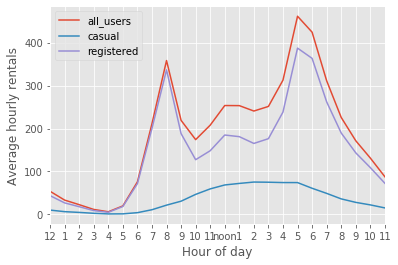

In [133]:
hour_pivot = processed_data.pivot_table(index='hour', values=['all_users', 'registered', 'casual'])
hour_pivot.plot()
plt.xlabel('Hour of day')
plt.ylabel('Average hourly rentals')
ticks = ['12', '1', '2', '3', '4', '5', '6', '7', '8', '9','10', '11', 
         'noon', '1', '2', '3', '4', '5', '6', '7', '8', 
         '9', '10', '11']
plt.xticks(np.arange(0,24, step=1), labels =ticks)

## casual users rent more on weekends registered rent less

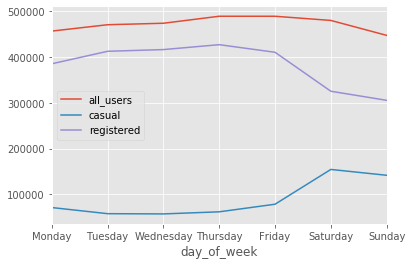

In [134]:
style.use('ggplot')
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_of_week_pivot = processed_data.pivot_table(index='day_of_week', values=['all_users', 'casual', 'registered'], aggfunc='sum')
day_of_week_pivot.loc[day_order].plot()


### season's affect on rentals

Text(0, 0.5, 'rentals')

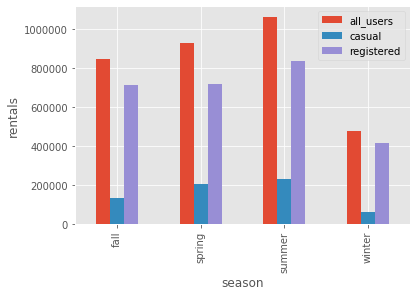

In [135]:
season_pivot = processed_data.pivot_table(index='season', values=['all_users', 'registered', 'casual'], aggfunc='sum')
season_pivot.plot.bar()
plt.ylabel('rentals')

### Weather's affect on rentals

Text(0.5, 1.0, 'Rentals are lower when there is precipitation')

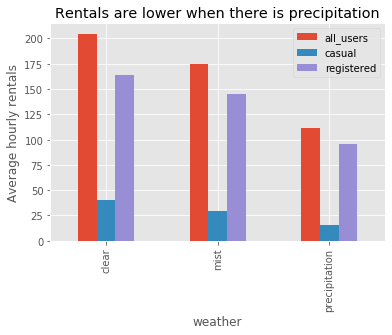

In [136]:
weather_pivot = processed_data.pivot_table(index='weather', values=['all_users', 'casual', 'registered'])
weather_pivot.plot.bar()
plt.ylabel('Average hourly rentals')
plt.title('Rentals are lower when there is precipitation')

# Analysis of all user type rentals

### splitting data into train and test

In [138]:
X_num = processed_data[['temp', 'windspeed', 'holiday', 'hour']].copy()
X_final = X_num.join([day_of_week_encoded, season_encoded, weather_encoded])
y_final = processed_data['all_users'].copy()

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.33, random_state = 0 )

In [139]:
len(X_train)

11697

In [140]:
len(X_test)

5762

In [141]:
len(y_train)

11697

In [142]:
len(y_test)

5762

### scaling data

In [143]:
s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test= s_scaler.transform(X_test.astype(np.float))

### fitting data to linear regression

In [144]:
lr = LinearRegression().fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)


In [145]:
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print('lr train score %.3f, lr test score: %.3f' % (
lr.score(X_train,y_train),
lr.score(X_test, y_test)))

lr.coef_: [ 7.93761705e+01  1.12980001e+01 -3.80036282e+00  5.95404588e+01
  3.95832289e+13  3.96426258e+13  3.95832289e+13  3.95931405e+13
  4.00245002e+13  3.93037209e+13  3.97608984e+13 -8.32780919e+14
 -8.42936359e+14 -8.41169141e+14 -8.30237635e+14  4.25088009e+14
  3.93158899e+14  2.46176397e+14]
lr.intercept_: 189.145382417729
lr train score 0.318, lr test score: 0.317


### fitting data to a random forest regression

In [146]:
forest = RandomForestRegressor(n_estimators = 100,
                              criterion = 'mse',
                              random_state = 1,
                              n_jobs = -1)

In [147]:
forest.fit(X_train,y_train.values.ravel())
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

In [148]:
print('forest train score %.3f, forest test score: %.3f' % (
forest.score(X_train,y_train),
forest.score(X_test, y_test)))

forest train score 0.973, forest test score: 0.820
